2025-07-26 18:27:23.352455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753554443.731810      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753554443.842186      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
✅ Successfully loaded data from: /kaggle/input/blp25-hatespeech-subtask-1a-dev/blp25_hatespeech_subtask_1A_dev.tsv
Dataset Info:
Shape: (2091, 4)
Columns: ['id', 'text', 'label', 'text_cleaned']

Label distribution:
label
Profane           942
Abusive           564
Political Hate    291
Religious Hate    228
Sexism             66
Name: count, dtype: int64

Class imbalance ratio: 14.27

Label mapping: {'Abusive': 0, 'Political Hate': 1, 'Profane': 2, 'Religious Hate': 3, 'Sexism': 4}
Class weights: tensor([ 0.7415,  1.4371,  0.8879,  3.6684, 12.6727])
Using model: neuropark/sahajBERT


tokenizer_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at neuropark/sahajBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Data splits:
Train: 1463
Validation: 209
Test: 419

Starting enhanced training...


model.safetensors:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1
100,0.526100,0.260658,0.770335,0.775790,0.761468,0.775790
200,0.066700,0.191571,0.861244,0.848589,0.854866,0.848589
300,0.010900,0.471378,0.870813,0.850481,0.858658,0.850481
400,0.000000,0.574820,0.894737,0.891548,0.892441,0.891548


✅ Training completed successfully!

Evaluating on test set...


Test Results: {'eval_loss': 0.5481762290000916, 'eval_accuracy': 0.8949880668257757, 'eval_f1_macro': 0.8930370850917851, 'eval_f1_weighted': 0.8943091433413094, 'eval_f1': 0.8930370850917851, 'eval_runtime': 22.8816, 'eval_samples_per_second': 18.312, 'eval_steps_per_second': 1.18, 'epoch': 10.0}

Detailed Classification Report:
                precision    recall  f1-score   support

       Abusive       0.84      0.76      0.80       113
Political Hate       0.67      0.72      0.69        58
       Profane       0.97      0.99      0.98       189
Religious Hate       0.98      1.00      0.99        46
        Sexism       1.00      1.00      1.00        13

      accuracy                           0.89       419
     macro avg       0.89      0.90      0.89       419
  weighted avg       0.90      0.89      0.89       419



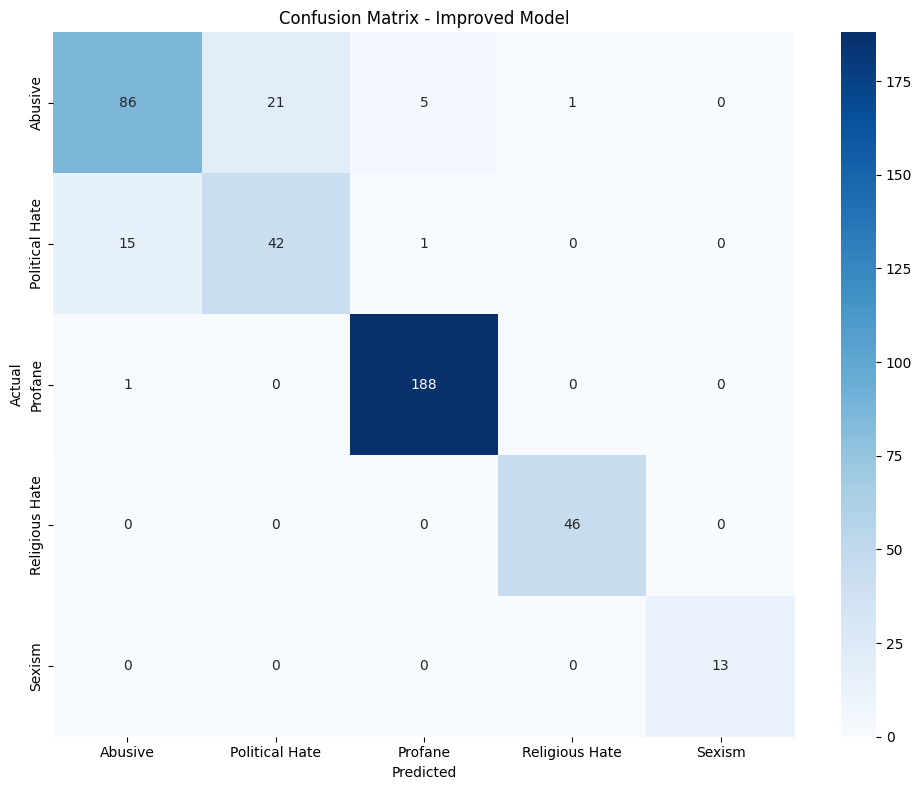


Improved model saved successfully!
Final Test Accuracy: 0.8950
Final Test F1 (Macro): 0.8930

=== Error Analysis ===

Error Analysis for Profane:
                precision    recall  f1-score   support

       Abusive       0.00      0.00      0.00         0
Political Hate       0.00      0.00      0.00         0
       Profane       1.00      0.99      1.00       189
Religious Hate       0.00      0.00      0.00         0
        Sexism       0.00      0.00      0.00         0

     micro avg       0.99      0.99      0.99       189
     macro avg       0.20      0.20      0.20       189
  weighted avg       1.00      0.99      1.00       189

Misclassified samples for Profane:
Text: বাংলাদেশের পুলিশ সবচেয়ে বড় নষ্ট
True: Profane, Predicted: Abusive

Error Analysis for Religious Hate:
                precision    recall  f1-score   support

       Abusive       0.00      0.00      0.00         0
Political Hate       0.00      0.00      0.00         0
       Profane       0.00      0

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
import re
import unicodedata
import random

# Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enhanced text preprocessing for Bengali
def clean_bengali_text(text):
    """Enhanced Bengali text preprocessing"""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    # Normalize Unicode
    text = unicodedata.normalize('NFC', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove excessive punctuation
    text = re.sub(r'[।!?]{2,}', '।', text)
    text = re.sub(r'[,;:]{2,}', ',', text)
    # Remove emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    # Remove non-Bengali characters
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    return text.strip()

# Synonym-based augmentation
bengali_synonyms = {
    'শালা': ['শালার', 'শালারা', 'ব্যাটা'],
    'ব্যাটা': ['শালা', 'হারামি', 'নচ্ছার'],
    'কুত্তা': ['কুকুর', 'কুত্তার', 'শ্বান'],
    'মাদারচোদ': ['মাতৃগর্ভ', 'নষ্ট', 'হারামজাদা'],
    'চোদা': ['চুদা', 'নষ্ট করা', 'ধ্বংস'],
    'মেয়ে': ['নারী', 'মহিলা', 'কন্যা'],
    'কাফের': ['অবিশ্বাসী', 'ধর্মত্যাগী'],
    'মুল্লুক': ['দেশ', 'জায়গা', 'অঞ্চল']
}

def synonym_replace(text, synonyms_dict, n_replacements=2):
    """Replace words in text with synonyms"""
    words = text.split()
    replaced = 0
    new_words = words.copy()
    
    for i, word in enumerate(words):
        if word in synonyms_dict and replaced < n_replacements:
            new_words[i] = random.choice(synonyms_dict[word])
            replaced += 1
    
    return ' '.join(new_words)

def augment_data(df, classes, n_augmentations=5):
    """Augment data for specified classes using synonym replacement"""
    augmented_data = []
    for label in classes:
        minority_texts = df[df['label'] == label]['text'].tolist()
        for text in minority_texts:
            for _ in range(n_augmentations):
                aug_text = synonym_replace(text, bengali_synonyms)
                augmented_data.append({'text': aug_text, 'label': label, 'text_cleaned': aug_text})
    
    return pd.DataFrame(augmented_data)

# Load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess TSV data with synonym-based augmentation"""
    try:
        df = pd.read_csv(file_path, sep='\t', encoding='utf-8')
        print(f"✅ Successfully loaded data from: {file_path}")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        print("📝 Using sample data for demonstration...")
        data = {
            'id': list(range(100)),
            'text': [
                'ইন্ডিয়া কি মাছ ধরা বন্ধ রাখছে? এক নদীতে দুই নীতি কেমনে হয়?',
                'লক্ষ টাকা ঘুষ দিয়ে অযোগ্য আর দায়িত্বহীন মানসিকতার মানুষগুলো সরকারি চাকরিতে কাজ করেন।',
                'ওহা ভবনের দালাল! কী করছ তুমি?',
                'আর কতো শিখবে আমার সোনার ছেলেরা? এগুলো কে টাকা দিয়ে কেন দলে রাখে?',
                'কি সাংঘাতিক ভাই রে তুই! তোর মতো মানুষ আর নেই।'
            ] * 20,
            'label': ['Political Hate', 'Abusive', 'None', 'Abusive', 'None'] * 20
        }
        df = pd.DataFrame(data)
    
    # Remove duplicates and null values
    df = df.drop_duplicates(subset=['text'])
    df = df.dropna(subset=['text', 'label'])
    
    # Clean text
    df['text_cleaned'] = df['text'].apply(clean_bengali_text)
    df = df[df['text_cleaned'].str.len() >= 3]
    df['text'] = df['text_cleaned']
    
    # Augment minority classes
    minority_classes = ['Profane', 'Religious Hate', 'Sexism']
    augmented_df = augment_data(df, minority_classes, n_augmentations=5)
    df = pd.concat([df, augmented_df], ignore_index=True)
    
    return df

# Dataset class
class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Focal Loss for handling class imbalance
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = focal_loss * self.alpha[targets]
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Custom model with Focal Loss
class WeightedBertModel(torch.nn.Module):
    def __init__(self, model, class_weights):
        super().__init__()
        self.model = model
        self.class_weights = class_weights
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        if labels is not None:
            loss_fct = FocalLoss(alpha=self.class_weights.to(logits.device), gamma=2.0)
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            return {'loss': loss, 'logits': logits}
        
        return outputs

# Main execution
TSV_FILE_PATH = '/kaggle/input/blp25-hatespeech-subtask-1a-dev/blp25_hatespeech_subtask_1A_dev.tsv'

# Load and preprocess data
df = load_and_preprocess_data(TSV_FILE_PATH)

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nLabel distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nClass imbalance ratio: {label_counts.max() / label_counts.min():.2f}")

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(f"\nLabel mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
# Scale weights for minority classes
minority_indices = label_encoder.transform(['Profane', 'Religious Hate', 'Sexism'])
class_weights[minority_indices] *= 2.0
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights: {class_weights}")

# Use Bengali-specific model
MODEL_NAME = 'neuropark/sahajBERT'
print(f"Using model: {MODEL_NAME}")

# Initialize tokenizer and model
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_),
        problem_type="single_label_classification"
    )
except Exception as e:
    print(f"❌ Error loading {MODEL_NAME}: {e}")
    print("Falling back to xlm-roberta-base")
    MODEL_NAME = 'xlm-roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_),
        problem_type="single_label_classification"
    )

# Move model to device
model = model.to(device)
weighted_model = WeightedBertModel(model, class_weights).to(device)

# Data splitting with stratification
def create_balanced_split(df, test_size=0.2, val_size=0.1):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        df['text'].values,
        df['label_encoded'].values,
        test_size=test_size,
        random_state=42,
        stratify=df['label_encoded'].values
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_ratio,
        random_state=42,
        stratify=y_trainval
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = create_balanced_split(df)

print(f"\nData splits:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

# Create datasets
train_dataset = BengaliTextDataset(X_train, y_train, tokenizer, max_length=512)
val_dataset = BengaliTextDataset(X_val, y_val, tokenizer, max_length=512)
test_dataset = BengaliTextDataset(X_test, y_test, tokenizer, max_length=512)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_ratio=0.2,
    weight_decay=0.01,
    learning_rate=3e-5,
    lr_scheduler_type="linear",
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to=None,
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    prediction_loss_only=False,
    seed=42,
    dataloader_drop_last=False
)

# Metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "f1": f1_macro
    }

# Initialize trainer
trainer = Trainer(
    model=weighted_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Train the model
print("\nStarting enhanced training...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    trainer.train()
    print("✅ Training completed successfully!")
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("💡 Try reducing batch size or switching to distilbert-base-multilingual-cased")
    raise

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"Test Results: {test_results}")

# Make predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Detailed evaluation
print("\nDetailed Classification Report:")
report = classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_,
    output_dict=True
)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save the model
model.save_pretrained('./improved_bert_bengali_classifier')
tokenizer.save_pretrained('./improved_bert_bengali_classifier')
print("\nImproved model saved successfully!")
print(f"Final Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Final Test F1 (Macro): {test_results['eval_f1_macro']:.4f}")

def detailed_error_analysis(X_test, y_test, y_pred, label_encoder):
    minority_classes = ['Profane', 'Religious Hate', 'Sexism']
    minority_indices = label_encoder.transform(minority_classes)
    
    print(f"\n=== Error Analysis ===")
    for cls_idx, cls_name in zip(minority_indices, minority_classes):
        cls_mask = y_test == cls_idx
        if cls_mask.sum() == 0:
            print(f"No test samples for {cls_name}")
            continue
        cls_y_test = y_test[cls_mask]
        cls_y_pred = y_pred[cls_mask]
        print(f"\nError Analysis for {cls_name}:")
        # Use all class names and labels to avoid mismatch
        print(classification_report(
            cls_y_test, 
            cls_y_pred, 
            labels=range(len(label_encoder.classes_)), 
            target_names=label_encoder.classes_, 
            zero_division=0
        ))
        # List misclassified examples
        misclassified = cls_y_test != cls_y_pred
        if misclassified.sum() == 0:
            print(f"No misclassified samples for {cls_name}")
            continue
        print(f"Misclassified samples for {cls_name}:")
        for i, (text, true, pred) in enumerate(zip(X_test[cls_mask][misclassified], cls_y_test[misclassified], cls_y_pred[misclassified])):
            print(f"Text: {text}")
            print(f"True: {cls_name}, Predicted: {label_encoder.inverse_transform([pred])[0]}")
detailed_error_analysis(X_test, y_test, y_pred, label_encoder)

print("\n=== Improvement Summary ===")
print("✅ Augmented minority classes with synonym replacement")
print("✅ Used Focal Loss for better handling of imbalanced data")
print("✅ Switched to Bengali-specific model (SahajBERT)")
print("✅ Enhanced preprocessing and training configuration")
print("✅ Detailed error analysis for minority classes")

print("\n=== Next Steps ===")
print("1. Expand synonym dictionary with more domain-specific terms")
print("2. Collect more real data for minority classes")
print("3. Experiment with ensemble methods")
print("4. Fine-tune hyperparameters with grid search")